### Código + **Relatório**

**Aluno:** Savio Augusto Machado Araujo

---

### **Contexto do Problema**

Para a realização deste trabalho final, o problema escolhido para ser abordado consiste na tarefa de redução da complexidade geométrica de modelos 3D, que visa não só reduzir imensamente o tamanho dos arquivos de objetos em disco como também e, principalmente, otimizar o uso de recursos gráficos de quaisquer máquinas ou dispositivos que precisam executar a renderização, seja em animações ou jogos 3D. A otimização de polígonos é assunto recorrente principalmente nas comunidades de desenvolvimento de jogos, pois tem havido uma tendência por parte dos artistas ou as vezes *devs* atribuídos com tarefas de modelagem em criar modelos exageradamente complexos sem se preocupar com otimização geométrica, pois os recursos gráficos das placas de vídeo atuais têm se apresentado cada vez mais potentes; ainda, isso não justifica modelar de forma preguiçosa, ainda mais quando a otimização de modelos via redução de polígonos é realizada por algoritimos nos softwares de modelagem e não manualmente, contando apenas com uma boa modelagem manual inicial.

### **Redes GNG na Tarefa**

Com isso, relacionando o problema ao contexto da disciplina de Redes Neurais, pode-se aplicar modelos de redes GNG (Growing Neural Gas) para realizar a parte central desta tarefa, que é a redução da representação em nuvem de pontos dos modelos 3D. Como a informação final da rede é um grafo de forma representativa dos dados de entrada, inicialmente basta adaptar e avaliar diferentes números de neurônios para representarem os pontos originais; sob um contexto real, o número de neurônios poderia ser definido "sob demanda" antes de realizar a otimização, ao definir o número de vértices limite. Ainda que óbivo, vale citar que para tal otimização espera-se que o número de neurônios seja estritamente menor que a quantidade original de pontos no objeto 3D.

O objetivo é testar modelos de diferentes complexidades para avaliação. Obtendo-se os grafos, é possível realizar análise visual da conveniência do uso do modelo dada sua representatividade do objeto 3D original, bem como definir possíveis usos de modelos de diferentes complexidades quando inseridos em um contexto de desenvolvimento de jogos e animações.

---

Sendo assim, a implementação de GNG usada neste trabalho está disponível no GitHub [neste link](https://github.com/rendchevi/growing-neural-gas/blob/master/neuralgas.py); como essa implementação é apenas um reposítório e não um pacote disponível via `pip`, o código em questão foi entregue nesta mesma pasta (arquivo `neuralgas.py`), sem alterações no código original do autor, apenas para poupar a necessidade de download externo. Foi necessária a utilização de uma implementação externa às bibliotecas conhecidas pois essas possuíam apenas versões desatualizadas, não documentadas ou muitas vezes sequer possuíam uma implementação de redes GNG, dada sua arquitetura mais diferenciada.

Além disso, foram usadas as bibliotecas `matplotlib` e `imageio` para a criação de GIFs que apresentam a evolução de cada modelo durante o treinamento, visando uma representação mais lúdica e também mais completa da realização da tarefa.

In [1]:
from neuralgas import GrowingNeuralGas
from igraph import Graph
import numpy as np
import matplotlib.pyplot as plt
import imageio

A função `load_obj` abaixo foi implementada para carregar a nuvem de pontos de um arquivo `.obj` em um array `numpy` para uso como dados de entrada da rede GNG. Em um arquivo `.obj`, cada linha iniciada com o caractere `v` corresponde a um vértice, seguido de 3 coordenadas (X, Y e Z). Ainda, é necessário realizar uma rotação no objeto, dado que em uma abordagem puramente matemática comumente tem-se o plano XY como o "chão" e o eixo Z como a "altura", porém sob a abordagem dos *softwares* de modelagem 3D tem-se o plano XY como a "frente" e o eixo Z como a profundidade; isso se dá pela ideia de transição de um *canvas* 2D para um 3D.

In [2]:
def load_obj(filepath):
    points = []
    with open(filepath, 'r') as file:
        for line in file:
            if line.startswith('v '):
                coords = line.split()
                points.append([float(coords[1]), float(coords[2]), float(coords[3])])
    points = np.array(points)       
    theta = np.radians(90)
    rotation_matrix = np.array([
        [1, 0, 0],
        [0, np.cos(theta), -np.sin(theta)],
        [0, np.sin(theta), np.cos(theta)]
    ])
    points = np.dot(points, rotation_matrix)
    return points


def save_obj(filepath, points):
    with open(filepath, 'w') as file:
        for point in points:
            file.write(f'v {point[0]} {point[1]} {point[2]}\n')
            
            
def graph_to_numpy_array(graph:Graph):
    points = []
    for vertex in graph.vs:
        points.append(vertex['weight'])
    return np.array(points)

A função `plot_result` abaixo é responsável por plotar três figuras: a nuvem de pontos original do objeto, o grafo gerado pelo modelo GNG e a nuvem de pontos obtida desse mesmo grafo. Dessa forma, é possível comparar a representação original com a redução de pontos realizada, tanto no âmbito da *mesh* 3D quanto puramente na densidade de pontos. Vale notar que a função recebe um parâmetro `cmap`, relativo ao mapa de cores usado no eixo Z; esse mapa é um dos gradientes definidos na biblioteca `matplotlib` e visa facilitar a compreensão da forma do objeto 3D na projeção 2D, ao gerar diferenças de cor que agem como "sombras".

In [3]:
def plot_result(points_orig, gng_graph, cmap):
    fig = plt.figure(figsize=(15, 5))
    ax = fig.add_subplot(131, projection='3d')
    ax.set_title(f'Original')
    x = points_orig[:, 0]
    y = points_orig[:, 1]
    z = points_orig[:, 2]
    ax.scatter(x, y, z, cmap=cmap, c=z)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    ax.set_box_aspect([np.ptp(x), np.ptp(y), np.ptp(z)])


    ax = fig.add_subplot(132, projection='3d')
    ax.set_title(f'GNG ({len(gng_graph.vs)} neurons)')
    for edge in gng_graph.es:
        v1 = gng_graph.vs[edge.source]
        v2 = gng_graph.vs[edge.target]
        ax.plot([v1['weight'][0], v2['weight'][0]], 
                [v1['weight'][1], v2['weight'][1]], 
                [v1['weight'][2], v2['weight'][2]], 
                color='red', linewidth=0.5, alpha=0.5)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    ax.set_box_aspect([np.ptp(x), np.ptp(y), np.ptp(z)])

    ax = fig.add_subplot(133, projection='3d')
    ax.set_title(f'GNG Point Cloud')
    points_reduced = graph_to_numpy_array(gng_graph)
    x_reduced = points_reduced[:, 0]
    y_reduced = points_reduced[:, 1]
    z_reduced = points_reduced[:, 2]
    ax.scatter(x_reduced, y_reduced, z_reduced, cmap=cmap, c=z_reduced, s=10)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    ax.set_box_aspect([np.ptp(x), np.ptp(y), np.ptp(z)])

    plt.show()

A função `create_gif` abaixo realiza o condensamento da evolução do modelo GNG ao longo do treinamento em um GIF para melhor visualização do processo, e não apenas do resultado final. Além disso, a função foi implementada de forma a gerar GIFs de 10 segundos precisamente, dado o FPS de 10 fixo e a geração de 100 frames no total. A lista original de evolução de vértices e arestas possui até 50.000 passos de aprendizado no caso mais longo de treinamento, portanto essa lista foi reduzida de forma que só é obtido o grafo a cada 1% do total de passos de treinamento; no exemplo citado, seria obtido um grafo a cada 500 passos de aprendizado, portanto 50.000/500 = 100 grafos = 100 frames.

In [4]:
def create_gif(model, filename='evolution.gif'):
    v = model.verts_evolve[::(len(model.verts_evolve)//(model.max_iter//10))]
    e = model.edges_evolve[::(len(model.edges_evolve)//(model.max_iter//10))]
    
    with imageio.get_writer(filename, mode='I', fps=10) as writer:
        for verts, edges in zip(v, e):
            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')
            ax.set_title(f'GNG Evolution')
            for edge in edges:
                v1 = verts[edge[0] - 1]
                v2 = verts[edge[1] - 1]
                ax.plot([v1[0], v2[0]], [v1[1], v2[1]], [v1[2], v2[2]], color='red', linewidth=0.5, alpha=0.5)
            #ax.scatter(verts[:, 0], verts[:, 1], verts[:, 2], c='black', s=10)
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.set_zticklabels([])
            ax.set_box_aspect([np.ptp(verts[:, 0]), np.ptp(verts[:, 1]), np.ptp(verts[:, 2])])
            fig.canvas.draw()
            image = np.frombuffer(fig.canvas.renderer.buffer_rgba(), dtype='uint8')
            image = image.reshape(fig.canvas.get_width_height()[::-1] + (4,))
            plt.close(fig)
            writer.append_data(image) 
    print(f'GIF saved as {filename}')

### **Modelo: Cabeça**

O primeiro objeto 3D a ser apresentado aos modelos GNG consiste em uma cabeça humana genérica, com pescoço e parte dos ombros, contendo originalmente 20.000 pontos. Esse modelo é relativamente simples em termos de modelagem, sendo um bom experimento inicial para avaliar a adaptação da rede com diferentes limites de neurônios. Foram treinados 4 modelos diferentes, cujos parâmetros estão descritos na tabela a seguir:

|max_neurons|max_iters|
|-----------|---------|
|100|400|
|200|800|
|500|1000|
|1000|2000|

Vale notar que o máximo de iterações não é precisamente o número de passos de aprendizagem; considerando que o valor de `lambda` (parâmetro `l`) foi fixo em 50 e que esse valor determina a cada quantos passos a rede introduz um novo neurônio, na prática o número de passos de aprendizagem é `l * max_iter`.

Outro ponto importante é a escolha do máximo de iterações, para limites mais baixos de neurônios (100 e 200) foi dado 4x o limite de iterações, visto que cada iteração (50 passos) introduz um novo neurônio; já para limites maiores (500 e 100) o valor foi 2x o limite. Essa escolha visa dar tempo para a rede se adaptar melhor à forma 3D após terminar de introduzir novos neurônios, visando um modelo mais visualmente equilibrado que é desejado para manter proporções locais pós-redução de pontos.

Ademais, os parâmetros fixados foram `max_age=100`, `eb=0.1`, `en=0.001`, `alpha=0.5`, `beta=0.005` e `l=50` (valores "*default*" recomendados). Para esclarecimento, `eb` e `en` são a taxa de aprendizado do neurônio vencedor e seus vizinhos, respectivamente; `alpha` e `beta` são os multiplicadores do erro global e local. Como o foco desta implementação é avaliar a qualidade de diferentes graus de redução de pontos, apenas as variações de `max_neurons` e `max_iter` são realmente relevantes.

In [5]:
points = load_obj('Head.obj')
max_neurons = [100, 200, 500, 1000]
max_iters = [400, 800, 1000, 2000]
models_head = []
graphs_head = []

for n_max, i in zip(max_neurons, max_iters):
    model = GrowingNeuralGas(
        max_neurons=n_max,
        max_iter=i,
        max_age=100,
        eb=0.1,
        en=0.001,
        alpha=0.5,
        beta=0.005,
        l=50,
        dataset=points
    )
    graph:Graph = model.learn()
    models_head.append(model)
    graphs_head.append(graph)

100%|█████████▉| 1999/2000 [13:04<00:00,  2.55it/s]


Com os 4 modelos treinados, é possível avaliar os seus resultados. 

---

Primeiramente para o modelo de 100 neurônios, é possível observar que a rede GNG capturou realmente apenas a forma geral da cabeça, sem traços de informação de áreas mais complexas como orelhas, olhos ou boca. Apesar da simplicidade e perda de informação, modelos 3D com esse grau de complexidade são comumente utilizados para personagens de fundo que estão sempre distantes. Exemplos seriam jogos de esportes que possuem personagens em arquibancadas; como estarão sempre distantes e nunca em foco, pode-se utilizar modelos simples para seus corpos sem a necessidade de apresentar detalhes minusciosos do rosto.

---

Já para o modelo de 200 neurônios, tem-se uma noção da disposição das orelhas e uma melhor definição da mandíbula e da região dos olhos, ainda que de forma simples. Ainda que um modelo desse grau de complexidade não seja conveniente para personagens no qual a câmera estará em foco, ainda é muito bem utilizável para personagens secundários. Exemplos comuns incluem jogos de mundo aberto que contém cidades ou vilas; esses locais precisam ser populados para tornar o jogo "vivo", porém uma região com alta densidade de personagens mais complexos é sempre impraticável dada a demanda de recursos gráficos para tal. Assim, com técnicas como *normal-mapping*, modelos desse nível podem ser aplicados para personagens secundários no cenário.

---

No modelo de 500 neurônios já é possível identificar muito mais detalhes, incluindo as regiões antes perdidas ou simplificadas do rosto e das orelhas. Um modelo como esse já permite também a criação de animações melhores para fala e/ou expressões faciais mais versáteis e complexas. Com esse grau de complexidade já pode-se pensar em personagens primários ou principais, contanto que a temática gráfica do jogo não foque em realismo; para jogos de arte estilizada ou com design sub-realista, essa complexidade pode ser suficiente para os modelos principais.

---

Por fim, no modelo de 1000 neurônios já quase não se vê as "bordas rudes" dos polígonos, sem contar que todas as áreas da face são melhor definidas e detalhadas. Esse modelo começa a atingir a margem na qual o retorno visual ao aumentar o número de pontos não compensa diante da complexidade adicional, pois pode-se facilmente imaginar a *mesh* gerada e sobreposta de uma superfície com *normal-mapping* como uma representação altamente fiel do modelo original, mesmo que tenha apenas 5% do volume de pontos. Com esse grau de complexidade, já é possível criar personagens realistas com expressões complexas e fluídas, ou mesmo trabalhar em estilos cartunizados com maior flexibilidade de animação.

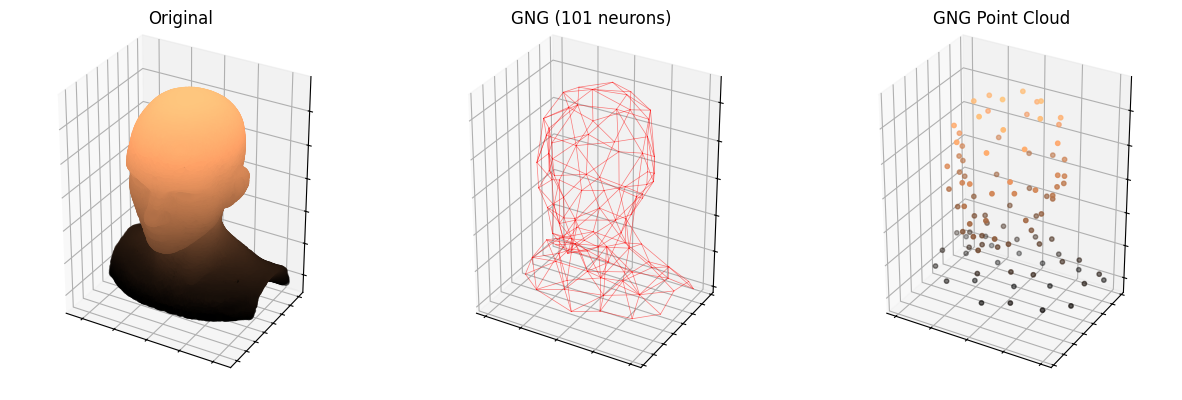

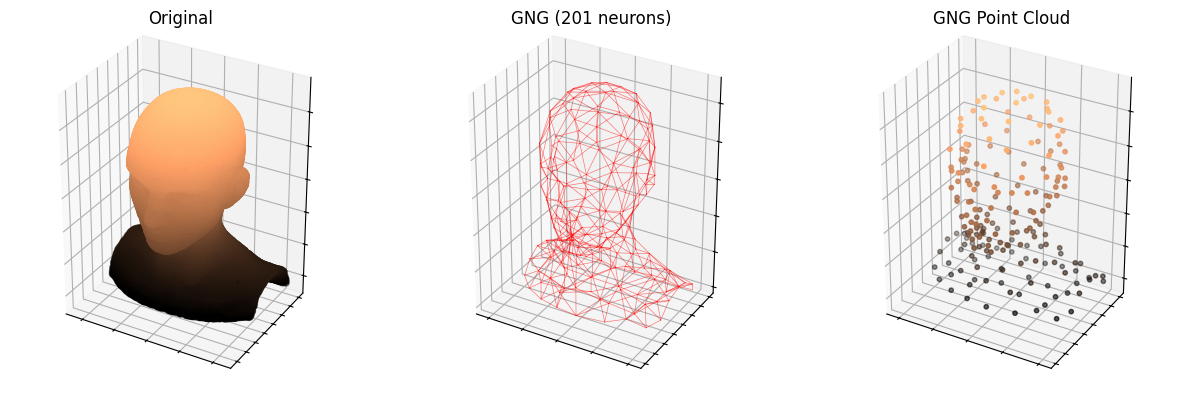

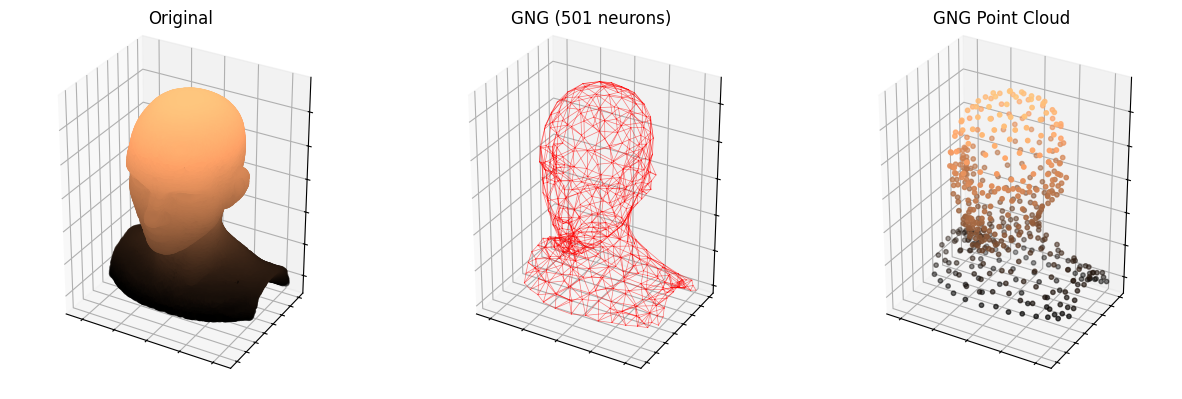

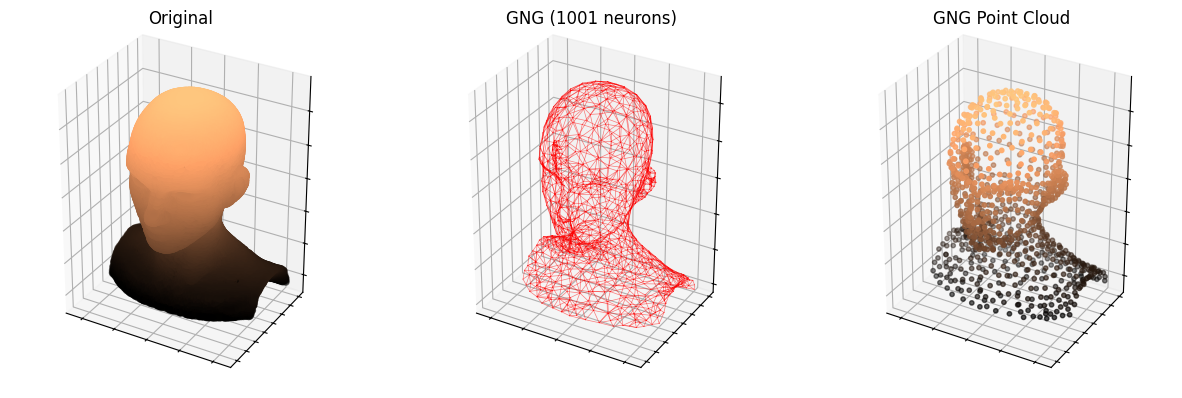

In [6]:
for graph in graphs_head:
    plot_result(points, graph, cmap='copper')

Abaixo foi realizado apenas o salvamento dos GIFs da evolução dos 4 modelos ao longo do treinamento. Os GIFs estão disponíveis na pasta `/gifs` neste mesmo diretório, nomeados de acordo com o objeto de referência e o número máximo de neurônios.

In [27]:
for model in models_head:
    create_gif(model, f'gifs/evolution_head_{model.max_neurons}n.gif')

GIF saved as gifs/evolution_head_100n.gif
GIF saved as gifs/evolution_head_200n.gif
GIF saved as gifs/evolution_head_500n.gif
GIF saved as gifs/evolution_head_1000n.gif


### **Modelo: Cachorro**

O segundo objeto 3D a ser apresentado aos modelos GNG consiste em um cachorro genérico, contendo originalmente 8.000 pontos. Apesar do número menor de pontos em relação ao objeto anterior, este modelo apresenta forma mais complexa e, diferente da cabeça, é um corpo completo para um personagem que permite avaliar o ajuste dos modelos quando o limite de neurônios porposto refere-se ao personagem completo; na prática, comumente o corpo inteiro do personagem é otimizado de uma vez e não suas partes individuais. 

Foram treinados 4 modelos diferentes, sob os mesmos parâmetros descritos para o primeiro objeto, a fim de avaliar redes de limitações iguais em cenários onde a complexidade do objeto original é crescente. Vale lembrar que a menor quantia de pontos não define sozinha a complexidade do objeto, como poderá ser visto à frente.

In [28]:
points = load_obj('Dog.obj')
max_neurons = [100, 200, 500, 1000]
max_iters = [400, 800, 1000, 2000]
models_dog = []
graphs_dog = []

for n_max, i in zip(max_neurons, max_iters):
    model = GrowingNeuralGas(
        max_neurons=n_max,
        max_iter=i,
        max_age=100,
        eb=0.1,
        en=0.001,
        alpha=0.5,
        beta=0.005,
        l=50,
        dataset=points
    )
    graph:Graph = model.learn()
    models_dog.append(model)
    graphs_dog.append(graph)

100%|█████████▉| 1999/2000 [13:05<00:00,  2.54it/s]


Com os 4 modelos treinados, é possível avaliar os seus resultados. 

---

Primeiramente para o modelo de 100 neurônios, vê-se que o resultado obtido não teria uso prático em condições normais; o formato do corpo fica generalizado para um animal de quatro patas qualquer, perde-se a certeza da noção original do cachorro. Além disso, do ponto de vista da modelagem 3D uma rede GNG pode gerar regiões como as vistas nas patas do cachorro gerado: apenas linhas no grafo, sem ciclos e portanto sem polígonos. Ao transformar os pontos em um objeto 3D, não há como criar superfícies em regiões assim. Com isso, o resultado não teria uso prático.

---

Já para o modelo de 200 neurônios, é possível obter alguns detalhes extras que trazem o reconhecimento do animal como um cachorro, com melhores definições principalmente da cabeça do animal. Ainda, o problema da falta de polígonos na região das patas persiste, porém a presença de mais neurônios nas patas pode possiblitar uma geração simples de polígonos entre as bases das patas e o restante do corpo. Essa abordagem dificultaria a criação de animações, porém seria suficiente para modelos estáticos ou de fundo. Também vale citar que foi gerado algum ruído entre as patas frontais, porém como essa região também não fecha formas geométricas isso não seria um problema muito relevante.

---

No modelo de 500 neurônios persiste o problema das patas, porém em escala muito menor e as regiões geradas apenas com linhas são mais facilmente corrigíveis e não afetariam gravemente as capacidades de animação como no caso anterior. Além disso, o corpo do animal se torna bem melhor definido, pode-se ter uma boa noção de seu porte e das características da cabeça. Muitos jogos que contém cachorros os têm como complementos secundários, personagens de fundo; um modelo nesse grau de complexidade com ajustes nas regiões problemáticas citadas poderia ser tranquilamente usado para estes casos.

---

Por fim, no modelo de 1000 neurônios pode-se observar todos os detalhes ao longo das patas sem problemas, bem como melhor definição do corpo e principalm,ente da cabeça; aqui já não se ganha muitos detalhes na cabeça ou mesmo no corpo em geral, colocando a maior densidade de pontos em questão. Novamente, esse grau de complexidade seria melhor aplicado à contextos com estilo de arte baseada em realismo, onde é sempre necessário obter mais detalhes.

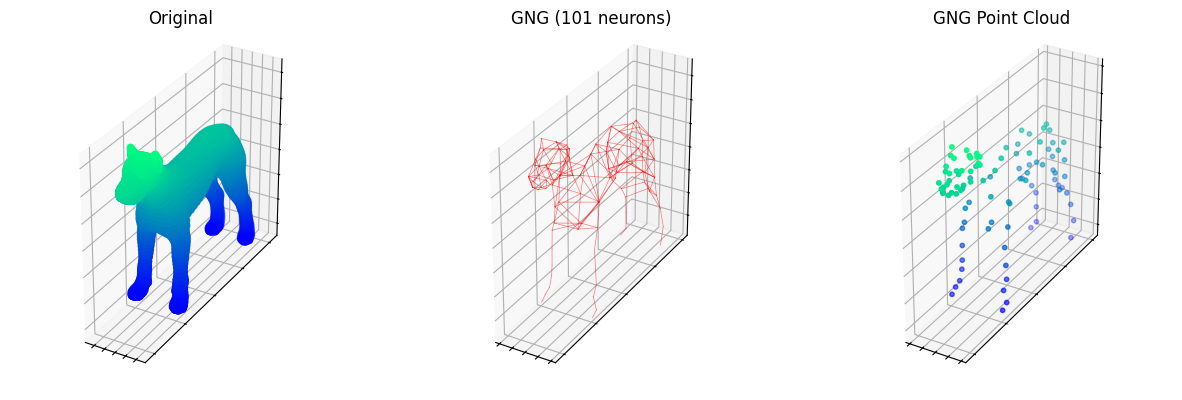

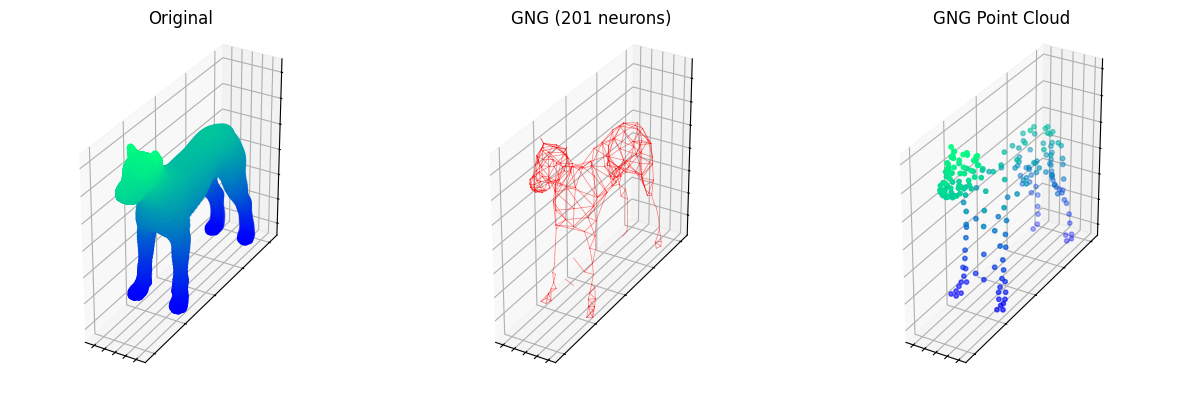

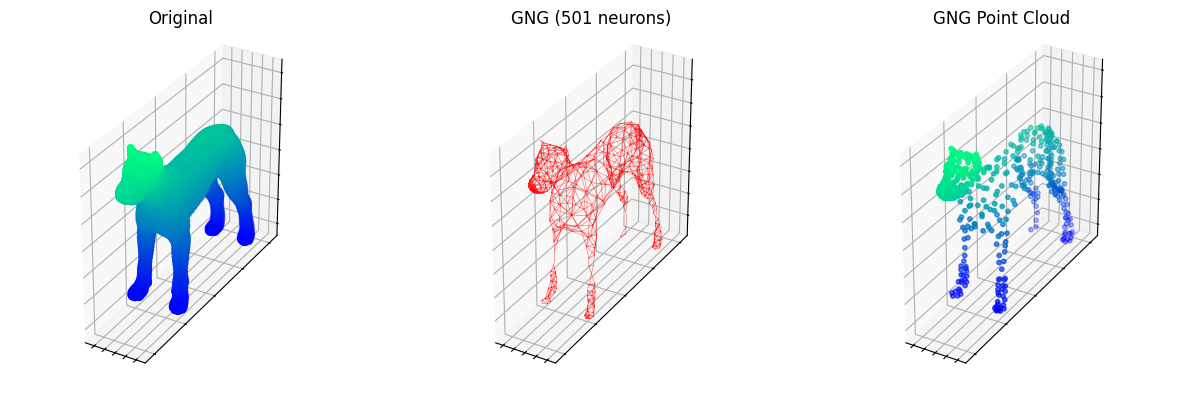

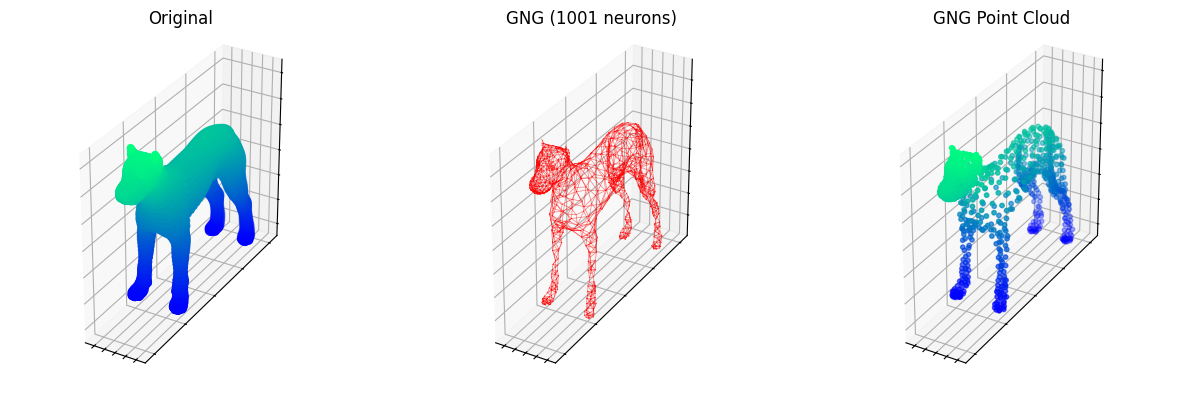

In [29]:
for graph in graphs_dog:
    plot_result(points, graph, cmap='winter')

Abaixo foi realizado apenas o salvamento dos GIFs da evolução dos 4 modelos ao longo do treinamento. Os GIFs estão disponíveis na pasta `/gifs` neste mesmo diretório, nomeados de acordo com o objeto de referência e o número máximo de neurônios.

In [30]:
for model in models_dog:
    create_gif(model, f'gifs/evolution_dog_{model.max_neurons}n.gif')

GIF saved as gifs/evolution_dog_100n.gif
GIF saved as gifs/evolution_dog_200n.gif
GIF saved as gifs/evolution_dog_500n.gif
GIF saved as gifs/evolution_dog_1000n.gif


### **Modelo: Anão Forjador**

O terceiro e último objeto 3D a ser apresentado aos modelos GNG consiste em um anão forjador, com não só o corpo inteiro do anão em questão mas também seu equipamento corporal, martelo e sua bigorna, contendo originalmente 20.000 pontos. O modelo possui alta complexidade em relação aos anteriores, pois agora há diversos objetos extras relacionados ao modelo que devem ser juntamente otimizados e representados pela rede GNG. Vale notar que essa otimização, na prática, seria ao menos separada em duas: uma para o anão e seu equipamento, outra para a bigorna. Ainda assim, é um cenário interessante para se avaliar co comportamento da rede nesse conjunto de uma vez.

Foram treinados 4 modelos diferentes, sob os mesmos parâmetros descritos para o primeiro objeto, a fim de avaliar redes de limitações iguais em cenários onde a complexidade do objeto original é crescente.

In [7]:
points = load_obj('Dwarf.obj')
max_neurons = [100, 200, 500, 1000]
max_iters = [400, 800, 1000, 2000]
models_dwarf = []
graphs_dwarf = []

for n_max, i in zip(max_neurons, max_iters):
    model = GrowingNeuralGas(
        max_neurons=n_max,
        max_iter=i,
        max_age=100,
        eb=0.1,
        en=0.001,
        alpha=0.5,
        beta=0.005,
        l=50,
        dataset=points
    )
    graph:Graph = model.learn()
    models_dwarf.append(model)
    graphs_dwarf.append(graph)

100%|█████████▉| 1999/2000 [13:17<00:00,  2.51it/s]


Com os 4 modelos treinados, é possível avaliar os seus resultados. 

---

Primeiramente para o modelo de 100 neurônios, pode-se observar um modelo completamente sem uso prático e até mesmo sem forma definida. Dada a complexidade do objeto original, apenas 100 neurônios conseguem apenas capturar a essência da forma do objeto de maneira extremamente minimalista; o resultado é muito visualmente abstrato e sem a referência original não seria remotamente possível remontar a ideia do anão e sua bigorna.

---

Já para o modelo de 200 neurônios, apesar do modelo resultante ainda não possuir uso prático é possível obter algums informações melhores de forma e diferenciar o anão, o martelo e a bigorna. Ainda assim, modelos tão simples são vistos apenas em jogos da época das primeiras transições do 2D para o 3D. Era esperado que menores quantidades de neurônios gerassem modelos não usáveis para este objeto, dada sua complexidade com a presença de muitas formas variadas.

---

No modelo de 500 neurônios tem-se enfim uma formação mais detalhada do objeto, com definições mais claras do corpo do anão e dos objetos à sua volta, com separação entre o corpo e a bigorna, formação mais clara dos sapatos e das luvas. Ainda assim, as ferramentas do anão e os detalhes de seu equipamento corporal deixam a desejar, porém este nível de complexidade trabalhado com *normal-mapping* poderia se aplicar à jogos de fantasia simples, onde os detalhes de personagens secundários são mais dados pelas texturas do que pelo modelo 3D de fato. Além disso, esta complexidade de geometria permitiria animações corporais básicas, sem muitos detalhes complexos e definitivamente sem expressões faciais.

---

Por fim, no modelo de 1000 neurônios os detalhes são expressos de forma mais perceptível, como os dedos das mãos e áreas mais detalhadas da cabeça como face e cabelo. A bigorna também se apresenta melhor definida e sem tanto ruídos. Além disso, o martelo enfim têm uma forma mais correta e detalhes pequenos como particularidades da barba agora são detectáveis. Essa maior complexidade permite um trabalho mais eficaz entre texturas, relevo 3D e *normal-mapping* na cração de um modelo visualmente representativo e plenamente usável.

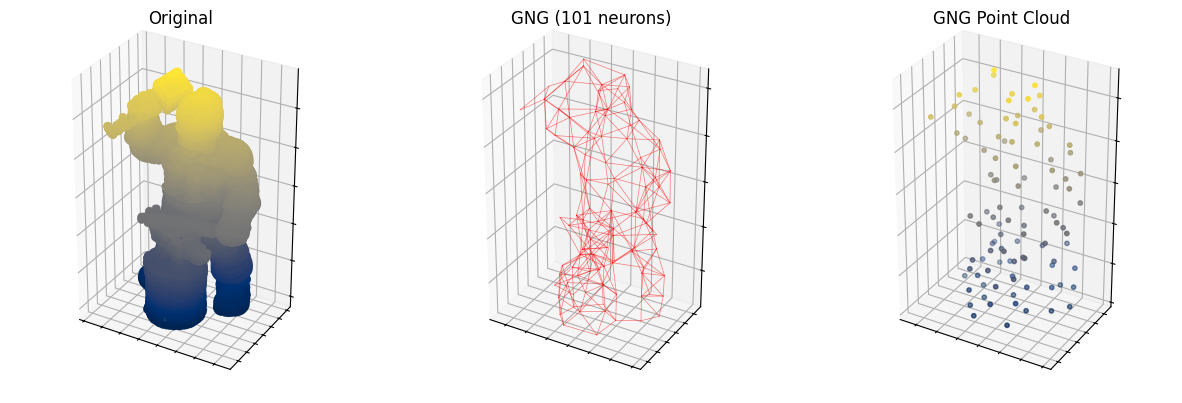

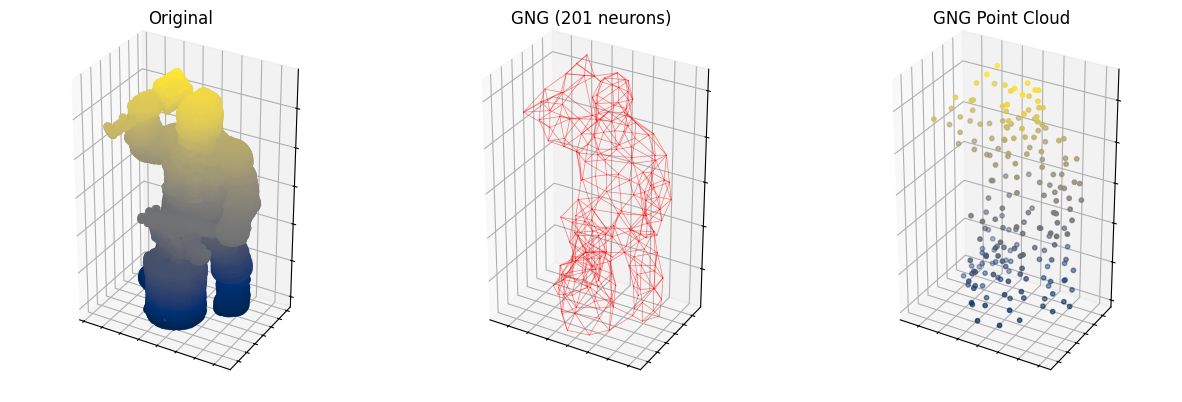

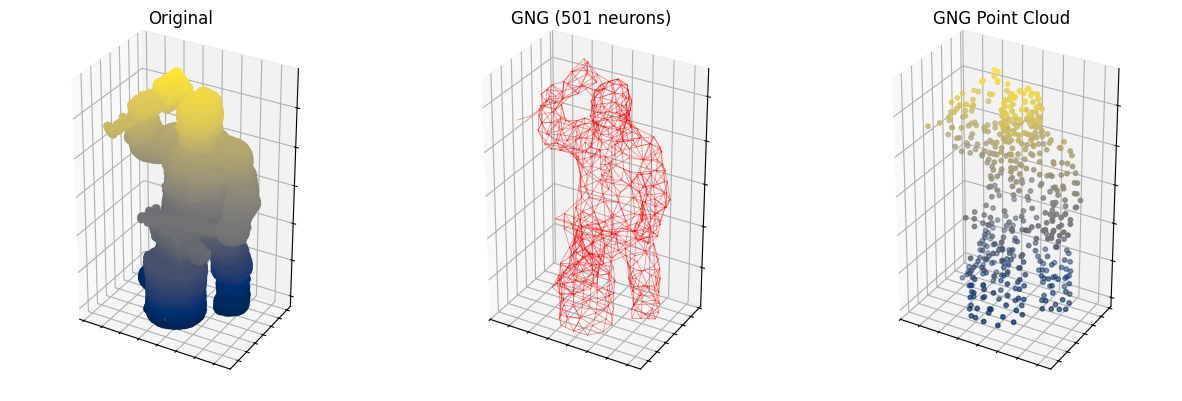

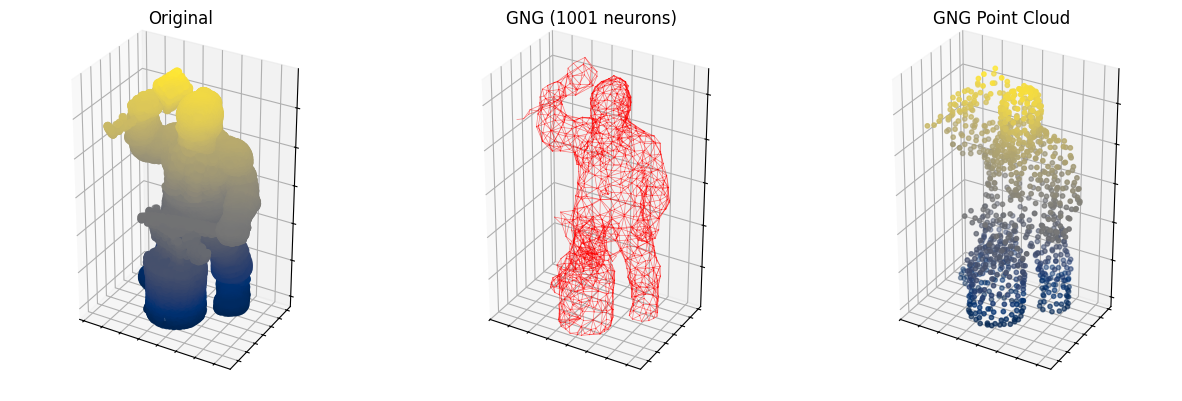

In [8]:
for graph in graphs_dwarf:
    plot_result(points, graph, cmap='cividis')

Abaixo foi realizado apenas o salvamento dos GIFs da evolução dos 4 modelos ao longo do treinamento. Os GIFs estão disponíveis na pasta `/gifs` neste mesmo diretório, nomeados de acordo com o objeto de referência e o número máximo de neurônios.

In [9]:
for model in models_dwarf:
    create_gif(model, f'gifs/evolution_dwarf_{model.max_neurons}n.gif')

GIF saved as gifs/evolution_dwarf_100n.gif
GIF saved as gifs/evolution_dwarf_200n.gif
GIF saved as gifs/evolution_dwarf_500n.gif
GIF saved as gifs/evolution_dwarf_1000n.gif
